In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation
from cil.io import NEXUSDataReader
from cil.utilities.display import show2D, show_geometry
from cil.plugins.astra import ProjectionOperator
from cil.plugins.astra.processors import FBP
from cil.plugins.ccpi_regularisation.functions import FGP_TV
from cil.optimisation.algorithms import FISTA
from cil.optimisation.functions import LeastSquares
from cil.processors import Padder

This notebook discusses the pros and cons of using the laminography geometry to image flat samples in 3D. For this example we use simulated data generated with the gVXR (GPU virtual x-ray) package which can be used to create realistic x-ray simulations.

We load a simulated dataset of a silica cylinder containing spheres, to start we will simulate the cylinder on the xz plane, i.e. orthogonal to the beam travelling along y and compute a single xray image.

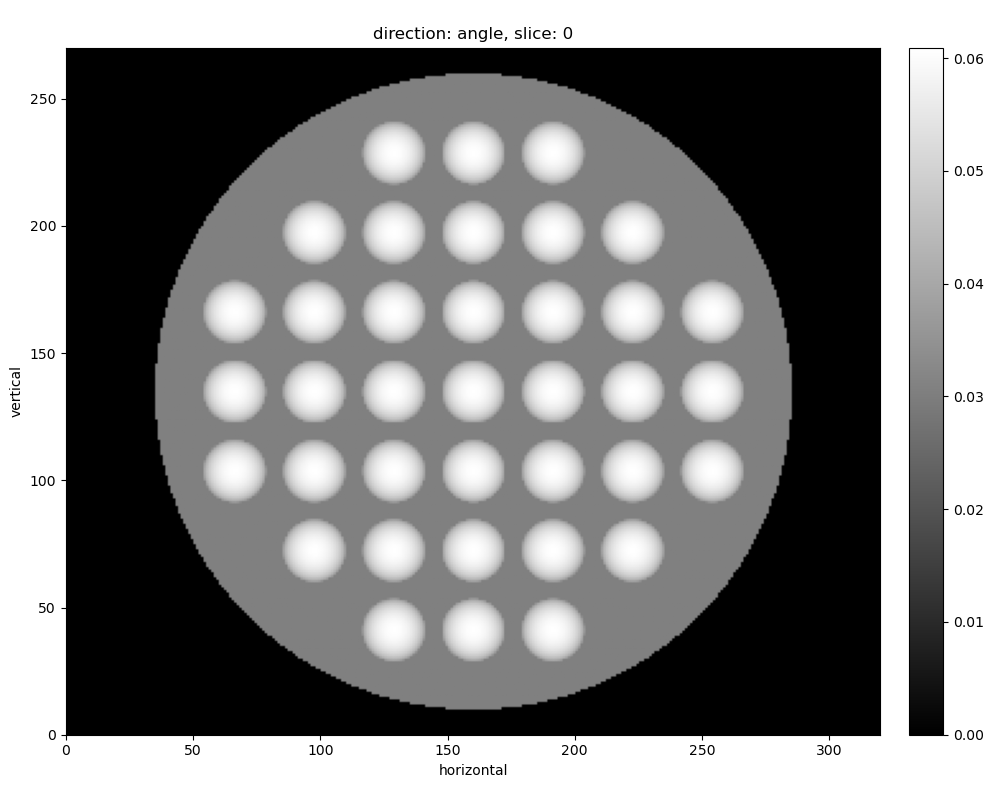

In [2]:
data = NEXUSDataReader("output_data/cylinder360.nxs").read()
show2D(data, slice_list=('angle',0))

To reconstruct these projections into a 3D volume we need to define the experimental geometry.

As above, we define the beam direction along the y axis, the detector in the x z plane, and rotation around z. We can view this geometry using `show_geometry`

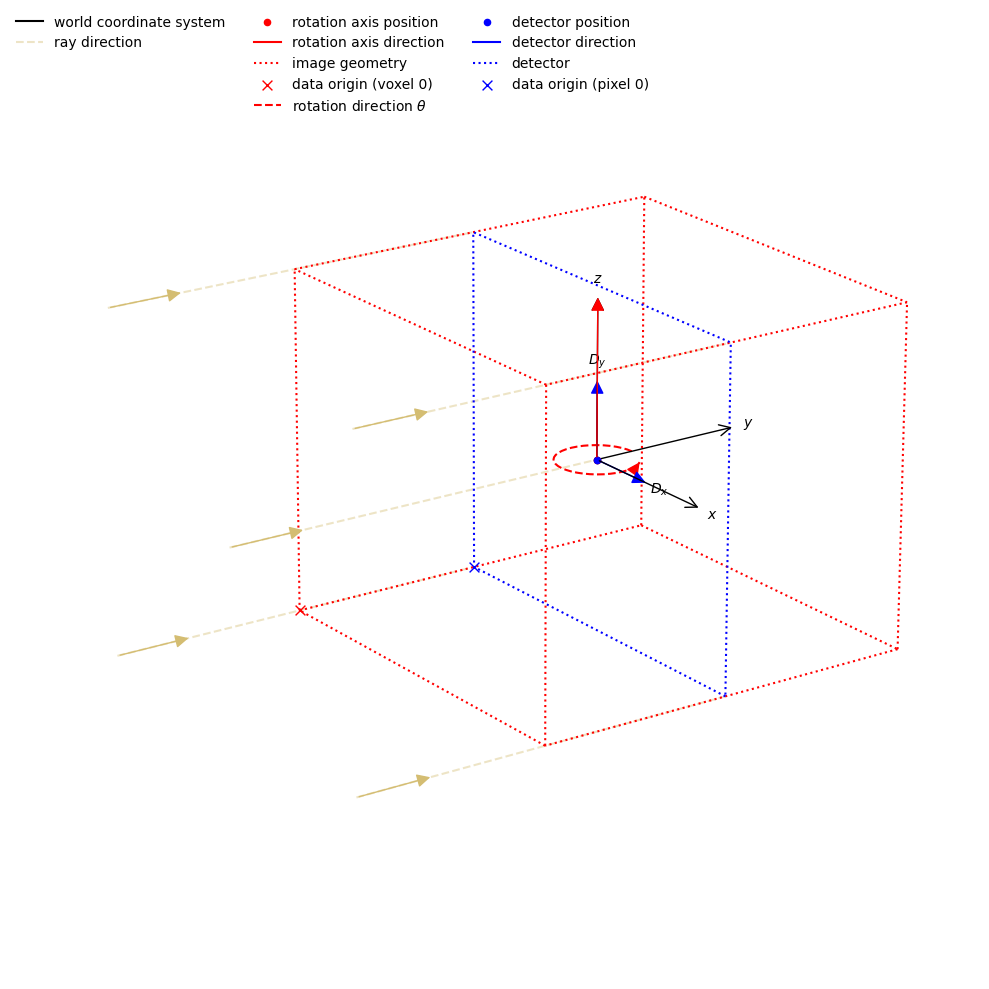

In [3]:
show_geometry(data.geometry)

Plot a range of angles

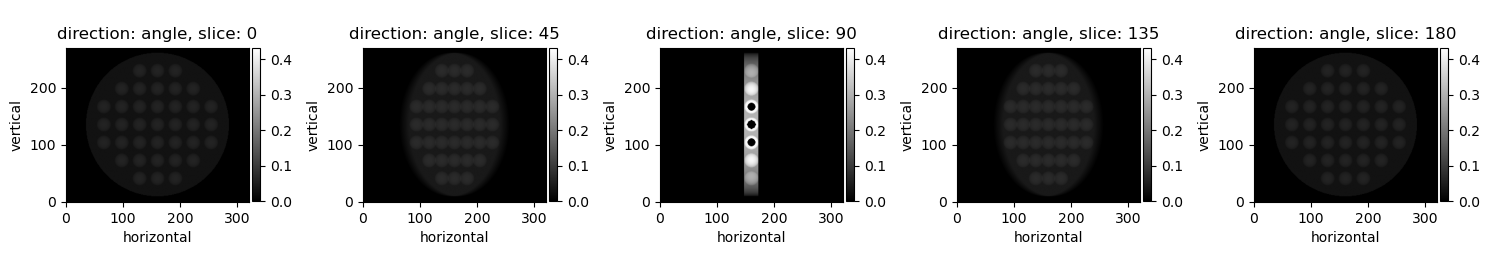

In [4]:
show2D(data, slice_list=[('angle', 0), ('angle', 45), ('angle',90), ('angle', 135), ('angle',180)], num_cols=5, fix_range=True)

Notice that the projections have quite different levels of intensity at different projections as we look through the long and short plane of the flat sample.

Let's see what it looks like if we try to reconstruct the grid from these projections. We use the filtered back projection (FBP) algorithm and view slices through the reconstructed volume.

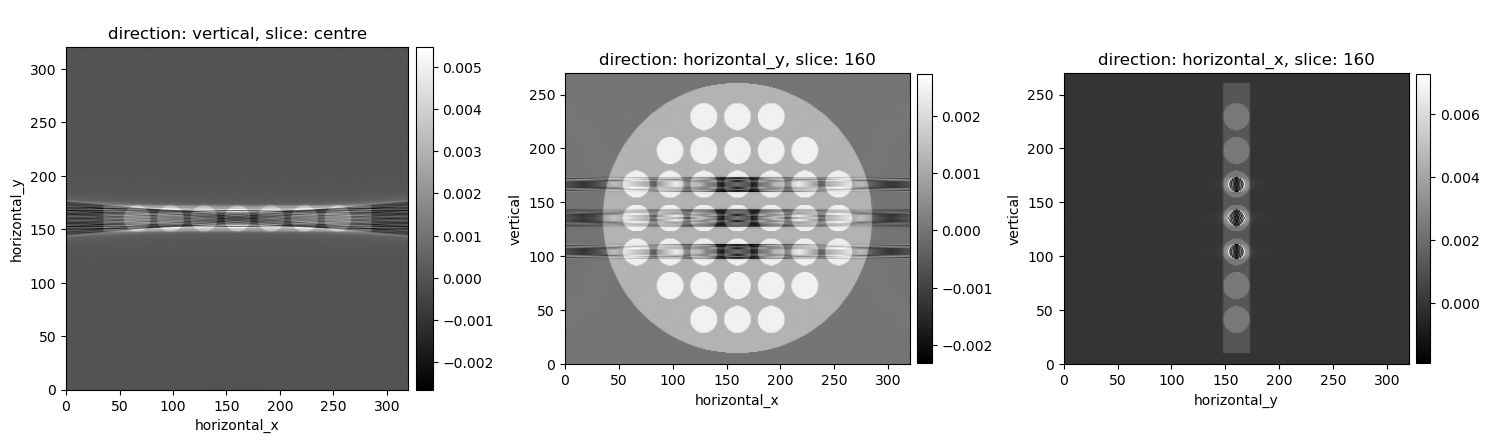

In [5]:
# Reconstruct using FBP
recon = FBP(image_geometry=None, acquisition_geometry=data.geometry)(data)

# Plot the results
slice_list = [('vertical','centre'), ('horizontal_y',int(recon.shape[1]/2)), ('horizontal_x',int(recon.shape[2]/2))]
show2D(recon,
       slice_list=slice_list,
       num_cols=3)

We notice some strange artefacts in the reconstruction. This is because of the anisotropic absorption we noticed in the projections. In practice, it's often not even possible to scan the sample along the long edge, so tomography scans are limited in angle and similar artefacts are seen. A common solution to these kind of artefacts is to tilt the sample and rotation axis to give a more uniform absorption profile, this setup is called laminography. We load a dataset simulated in the laminography setup by projecting the original grid volume with a tilted rotation axis. Here we define the tilt as the angle from the x-y plane, and simulated a 30 degree tilt.

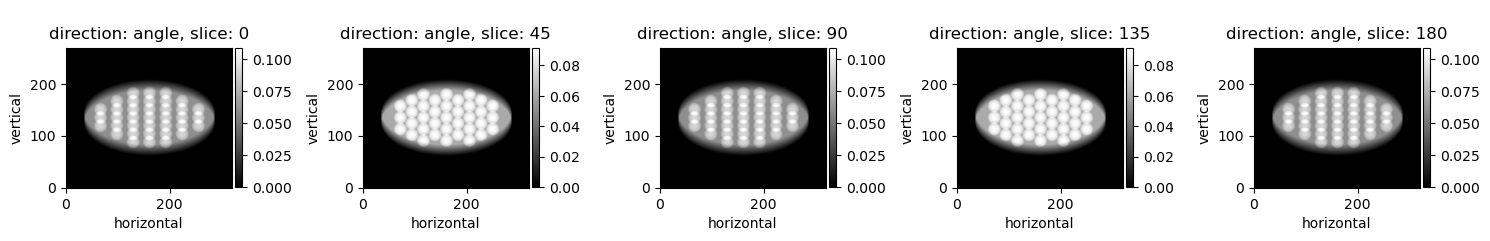

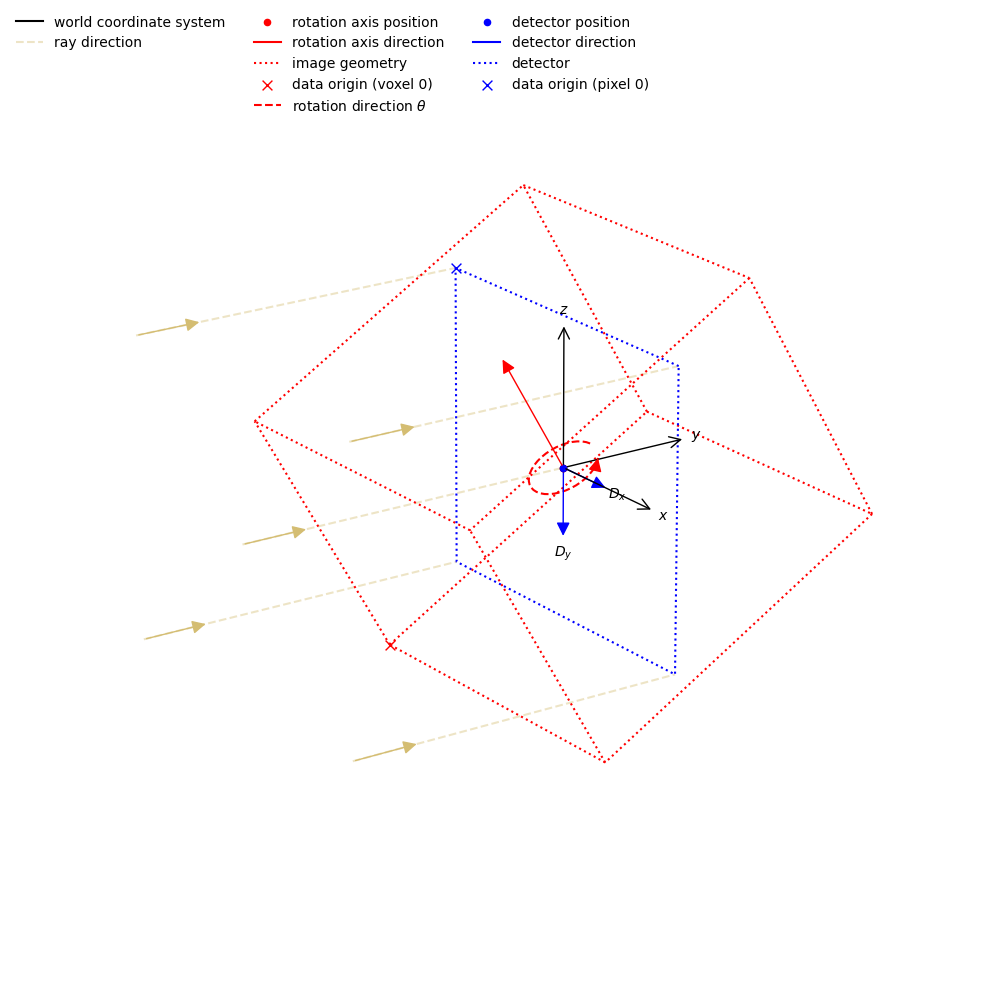

In [6]:
data = NEXUSDataReader("output_data/cylinder_tilt_30.nxs").read()
show2D(data, slice_list=[('angle', 0), ('angle', 45), ('angle',90), ('angle', 135), ('angle',180)], num_cols=5)
show_geometry(data.geometry)

The projections now have very uniform attenuation. Let's try reconstructing this dataset

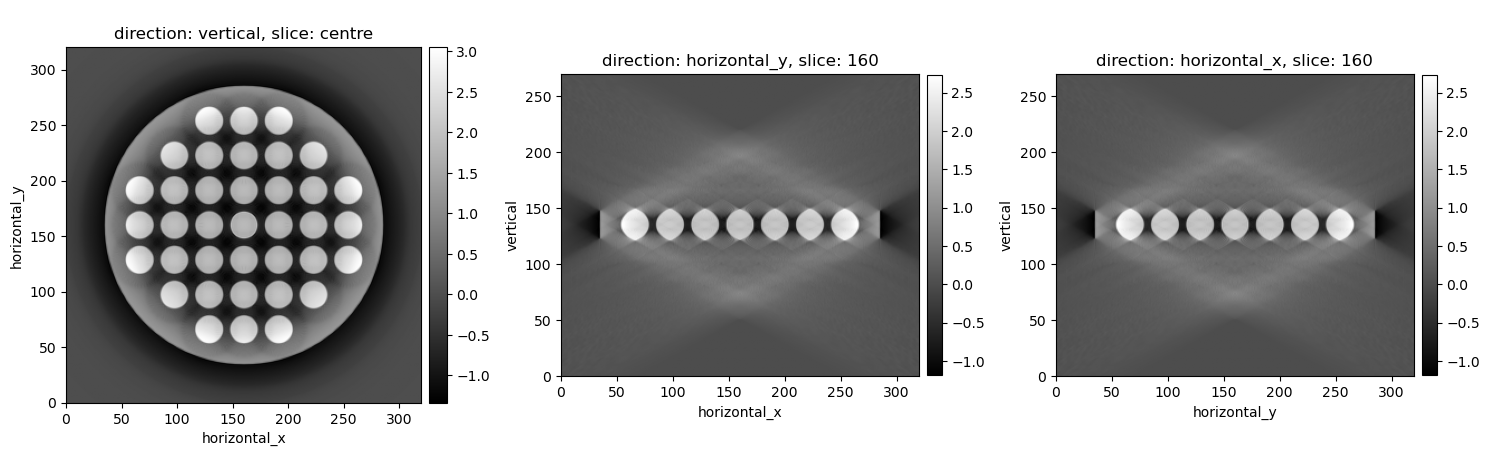

In [7]:
# Reconstruct using FBP
recon = FBP(image_geometry=None, acquisition_geometry=data.geometry)(data)

# Plot the results
slice_list = [('vertical','centre'), ('horizontal_y',int(recon.shape[2]/2)), ('horizontal_x',int(recon.shape[1]/2))]
show2D(recon,
       slice_list=slice_list,
       num_cols=3)

There are also artefacts in this reconstruction which are due to the way the laminography setup causes an uneven distribution of projections. When considering using the laminography setup, we need to balance the impact of the different kinds of artefacts. In general we should use the smallest tilt angle possible to reduce the projection anisotropy.

In [8]:
ag = data.geometry
ig = ag.get_ImageGeometry()
A = ProjectionOperator(ig, ag)

# Recontruct with FISTA least squares with non-negativity constraint
LS = LeastSquares(A=A, b=data)

alpha = 0.005
TV = FGP_TV(alpha=alpha, nonnegativity=True, device='gpu')

fista_TV = FISTA(initial=ig.allocate(0), f=LS, g=TV, update_objective_interval=10)
fista_TV.run(30)
TV_reco = fista_TV.solution

  0%|          | 0/30 [00:00<?, ?it/s]

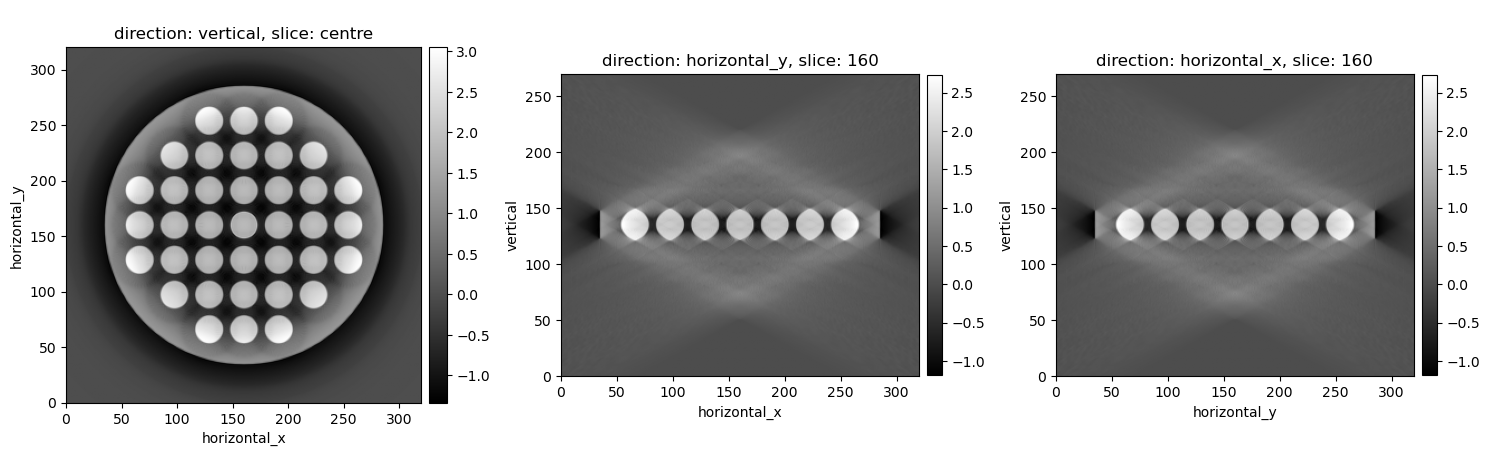

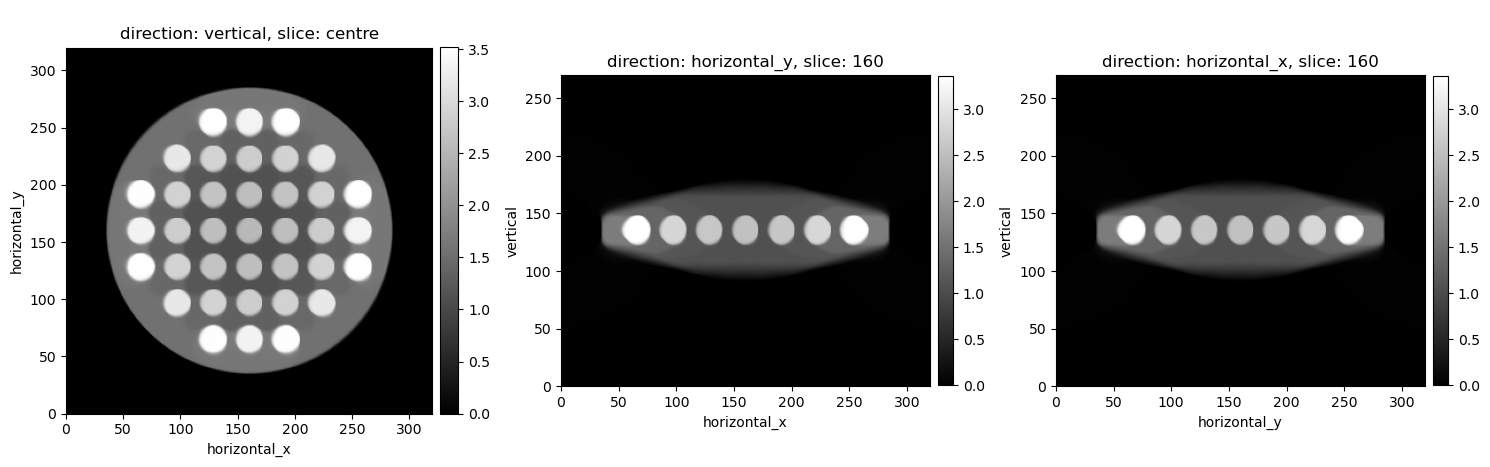

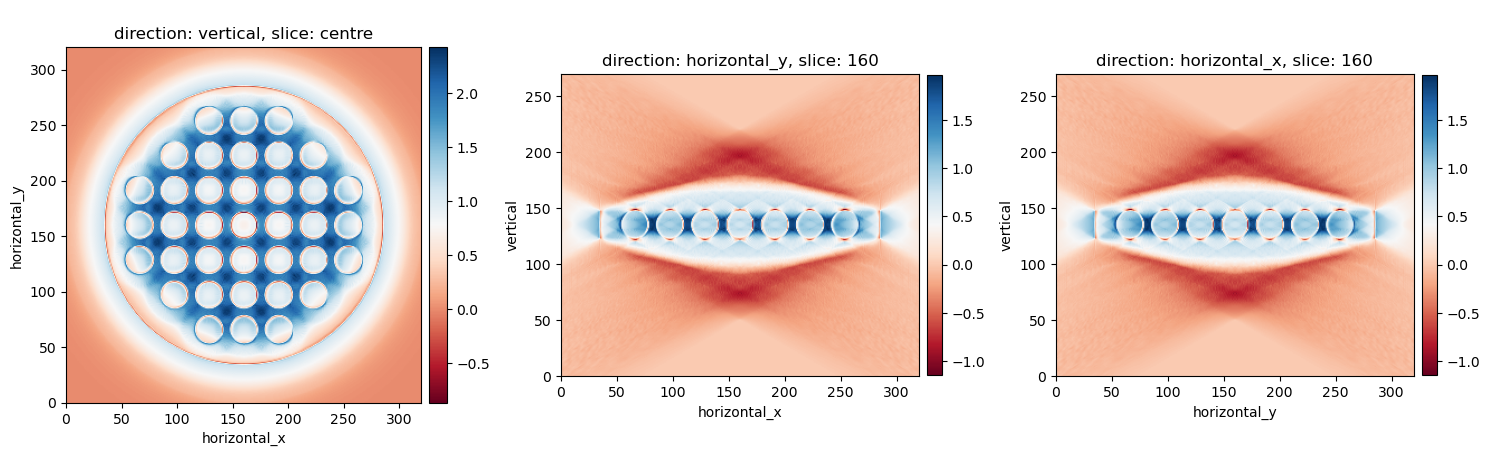

In [9]:
slice_list = [('vertical','centre'), ('horizontal_y',int(recon.shape[1]/2)), ('horizontal_x',int(recon.shape[2]/2))]
show2D(recon,
       slice_list=slice_list,
       num_cols=3)
slice_list = [('vertical','centre'), ('horizontal_y',int(TV_reco.shape[1]/2)), ('horizontal_x',int(TV_reco.shape[2]/2))]
show2D(TV_reco,
       slice_list=slice_list,
       num_cols=3)
show2D(TV_reco-recon,
       slice_list=slice_list,
       num_cols=3,
       cmap="RdBu")

Another common scenario with laminography samples, is that only a small region of interest (ROI) within the sample is fully scanned and parts of the sample outside the ROI will come in and out of view depending on the projection. We load a simulated dataset with this scenario with a larger cylinder

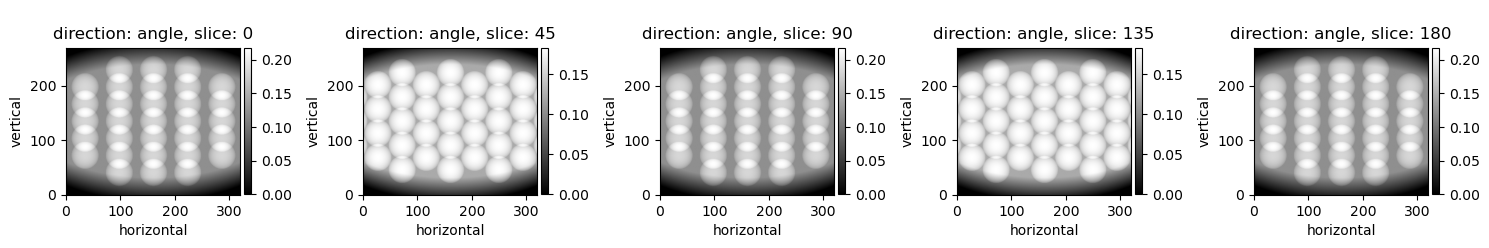

In [10]:
data = NEXUSDataReader("output_data/cylinder_roi_tilt_30.nxs").read()
show2D(data, slice_list=[('angle', 0), ('angle', 45), ('angle',90), ('angle', 135), ('angle',180)], num_cols=5)

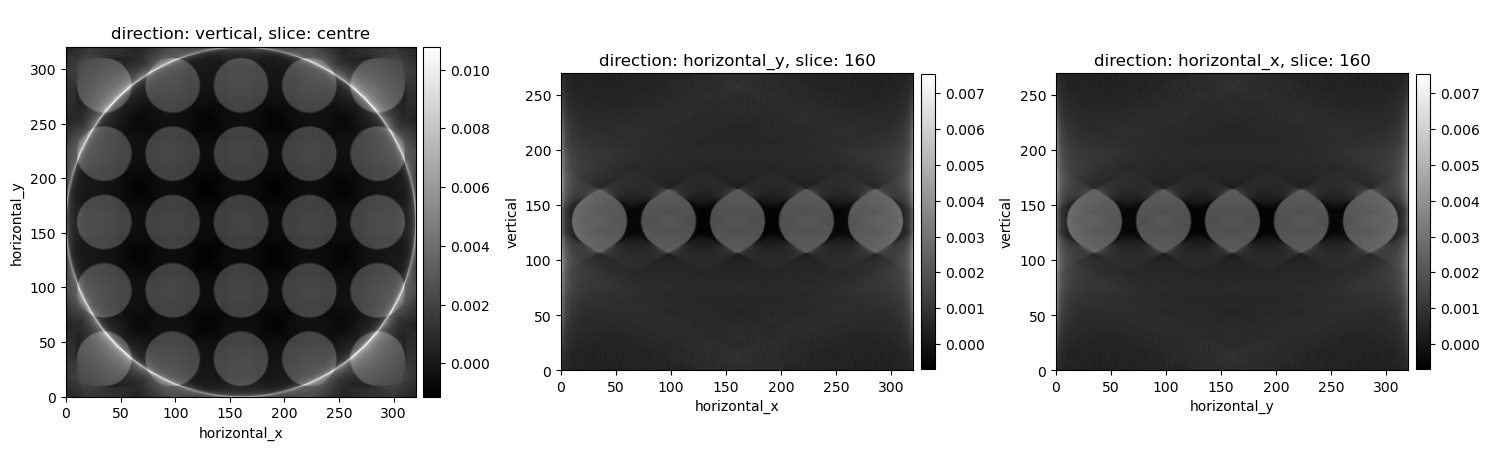

In [11]:
# Reconstruct using FBP
recon = FBP(image_geometry=None, acquisition_geometry=data.geometry)(data)

# Plot the results
slice_list = [('vertical','centre'), ('horizontal_y',int(recon.shape[2]/2)), ('horizontal_x',int(recon.shape[1]/2))]
show2D(recon,
       slice_list=slice_list,
       num_cols=3)

The reconstruction contains a bright ring, this is common with ROI data because the projections contain information from outside the ROI. To solve this we need to define an acquisition geometry which is larger than the detector to account for the information outside the ROI.

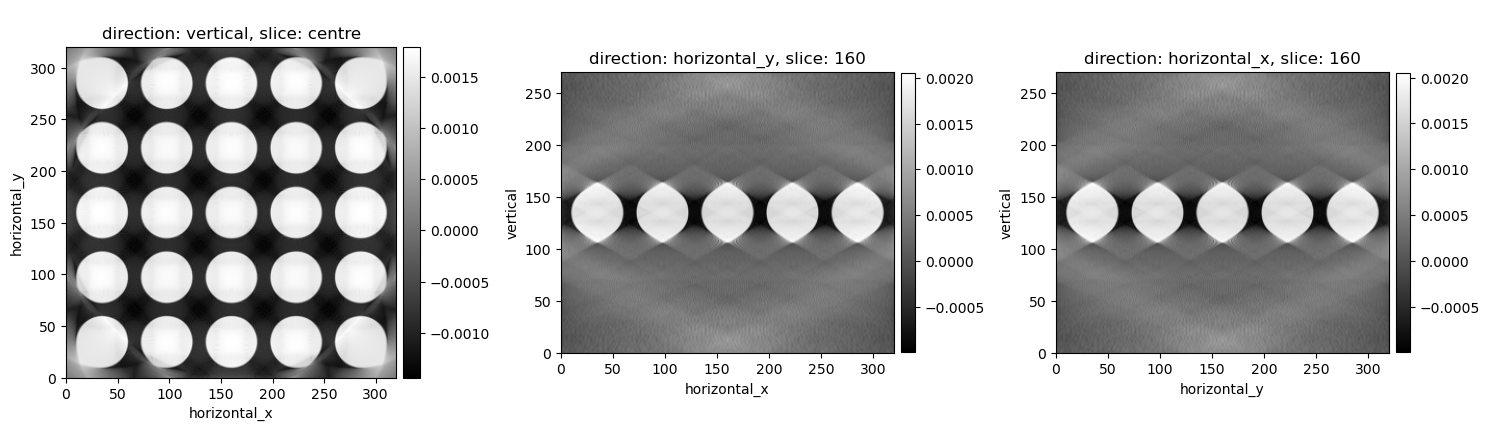

In [14]:
# Reconstruct using FBP
ig = data.geometry.get_ImageGeometry()
padsize = 200 # approximately the size of the object outside the detector (in pixels)
data_pad = Padder.edge(pad_width={'horizontal': padsize})(data)

recon = FBP(image_geometry=ig, acquisition_geometry=data_pad.geometry)(data_pad)

# Plot the results
slice_list = [('vertical','centre'), ('horizontal_y',int(recon.shape[2]/2)), ('horizontal_x',int(recon.shape[1]/2))]
show2D(recon,
       slice_list=slice_list,
       num_cols=3)